# b-tagging Machine Learning Tutorial

training script for DL1

In [3]:
import h5py
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [46]:
from keras.layers import BatchNormalization, TimeDistributed, ReLU, Layer
from keras.layers import Dense, Activation, Input, add, concatenate, Masking
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback
from keras import backend as K

In [4]:
%load_ext autoreload
%autoreload 2

In [7]:
from plottingFunctions import sigBkgEff

In [12]:
file_path = "../../btagging-ml_tutorial"
#file_path = "/eos/home-m/mguth/public/btagging-ml_tutorial_files"

In [13]:
trainfile_name = file_path+"/MC16d_hybrid-training_sample-DL1.h5"
h5f_train = h5py.File(trainfile_name, 'r')

In [29]:
X_trk_train = h5f_train['X_trk_train'][:]
X_train = h5f_train['X_train'][:]
Y_train = h5f_train['Y_train'][:]

In [15]:
testfile_name = file_path+"/MC16d_ttbar-test-validation_sample-DL1.h5"
h5f_test = h5py.File(testfile_name, 'r')

In [30]:
X_trk_test = h5f_test['X_test'][:]
X_test = h5f_test['X_test'][:]
Y_test = h5f_test['Y_test'][:]

In the following the DL1 network is defined

In [17]:
# Input layer
inputs = Input(shape=(X_train.shape[1],))
# number of nodes in the different hidden layers
l_units = [72, 57, 60, 48, 36, 24, 12, 6]
x = inputs
# loop to initialise the hidden layers
for unit in l_units:
    x = Dense(units=unit, activation="linear", kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = Dropout(0.1)
# output layer, using softmax which will return a probability for each jet to be either light, c- or b-jet
predictions = Dense(units=3, activation='softmax',
                    kernel_initializer='glorot_uniform')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

model_optimizer = Adam(lr=0.01)
model.compile(  # loss='mse',
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 72)                3240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72)                288       
_________________________________________________________________
activation_1 (Activation)    (None, 72)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 57)                4161      
_________________________________________________________________
batch_normalization_2 (Batch (None, 57)                228       
_________________________________________________________________
acti

In [18]:
def GetRejection(y_pred, y_true):
    """Calculates the c and light rejection for 77% WP and 0.018 c-fraction."""
    b_index, c_index, u_index = 2, 1, 0
    cfrac = 0.018
    target_beff = 0.77
    y_true = np.argmax(y_true, axis=1)
    b_jets = y_pred[y_true == b_index]
    c_jets = y_pred[y_true == c_index]
    u_jets = y_pred[y_true == u_index]
    bscores = np.log(b_jets[:, b_index] / (cfrac * b_jets[:, c_index] +
                                           (1 - cfrac) * b_jets[:, u_index]))
    cutvalue = np.percentile(bscores, 100.0 * (1.0 - target_beff))

    c_eff = len(c_jets[np.log(c_jets[:, b_index] / (cfrac * c_jets[:, c_index]
                                                    + (1 - cfrac) *
                                                    c_jets[:, u_index])) >
                       cutvalue]) / float(len(c_jets))
    u_eff = len(u_jets[np.log(u_jets[:, b_index] / (cfrac *
                                                    u_jets[:, c_index] +
                                                    (1 - cfrac) *
                                                    u_jets[:, u_index])) >
                       cutvalue]) / float(len(u_jets))

    if c_eff == 0 or u_eff == 0:
        return -1, -1
    return 1. / c_eff, 1. / u_eff


class MyCallback(Callback):
    """Custom callback function calculating per epoch light and c-rejection and saves the model of each epoch."""
    def __init__(self, X_valid=0, Y_valid=0,
                 model_name='test', store_all=False):
        self.X_valid = X_valid
        self.Y_valid = Y_valid
        self.result = []
        self.model_name = model_name
        os.system("mkdir -p %s" % self.model_name)
        self.dict_list = []
        self.store_all = store_all

    def on_epoch_end(self, epoch, logs=None):
        if self.store_all:
            self.model.save('%s/model_epoch%i.h5' % (self.model_name, epoch))
        y_pred = self.model.predict(self.X_valid, batch_size=5000)
        c_rej, u_rej = GetRejection(y_pred, self.Y_valid)
        dict_epoch = {
            "epoch": epoch,
            "loss": logs['loss'],
            "acc": logs['acc'],
            "val_loss": logs['val_loss'],
            "val_acc": logs['val_acc'],
            "c_rej": c_rej,
            "u_rej": u_rej
        }

        self.dict_list.append(dict_epoch)
        with open('%s/DictFile.json' % self.model_name, 'w') as outfile:
            json.dump(self.dict_list, outfile, indent=4)

In [20]:
Ntrain = 100

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.00001)
my_callback = MyCallback(X_valid=X_test,
                         Y_valid=Y_test,
                         model_name="DL1_example"
#                         ,store_all=True #flag to store model of each epoch
                        )

callbacks = [reduce_lr, my_callback]

model.fit(X_train[:Ntrain], Y_train[:Ntrain],
          validation_data=[X_test[:Ntrain], Y_test[:Ntrain]],
          epochs=10, # typically ~130 are necessary to converge
          batch_size=3000,
          callbacks=callbacks,
          )

Instructions for updating:
Use tf.cast instead.
Train on 100 samples, validate on 100 samples
Epoch 1/10
100/100 [==============================] - 6s 65ms/step - loss: 1.5034 - acc: 0.2700 - val_loss: 1.7610 - val_acc: 0.3300
Epoch 2/10
100/100 [==============================] - 0s 197us/step - loss: 1.3259 - acc: 0.2100 - val_loss: 1.4876 - val_acc: 0.3200


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Epoch 3/10
100/100 [==============================] - 0s 199us/step - loss: 1.1506 - acc: 0.3300 - val_loss: 1.5010 - val_acc: 0.3900
Epoch 4/10
100/100 [==============================] - 0s 186us/step - loss: 1.0086 - acc: 0.4300 - val_loss: 1.4133 - val_acc: 0.3800
Epoch 5/10
100/100 [==============================] - 0s 196us/step - loss: 0.9085 - acc: 0.5500 - val_loss: 1.2853 - val_acc: 0.3600
Epoch 6/10
100/100 [==============================] - 0s 179us/step - loss: 0.8240 - acc: 0.6500 - val_loss: 1.1575 - val_acc: 0.4000
Epoch 7/10
100/100 [==============================] - 0s 193us/step - loss: 0.7511 - acc: 0.7600 - val_loss: 1.1039 - val_acc: 0.5200
Epoch 8/10
100/100 [==============================] - 0s 189us/step - loss: 0.6837 - acc: 0.9200 - val_loss: 1.0611 - val_acc: 0.5500
Epoch 9/10
100/100 [==============================] - 0s 192us/step - loss: 0.6275 - acc: 0.9800 - val_loss: 1.0330 - val_acc: 0.5600
Epoch 10/10
100/100 [==============================] - 0s 164u

In [21]:
df_results = pd.read_json("DL1_example/DictFile.json")
df_results

,acc,c_rej,epoch,loss,u_rej,val_acc,val_loss
0,0.27,1.171180,0,1.503385,1.190626,0.33,1.760967
1,0.21,1.219292,1,1.325942,1.071544,0.32,1.487620
2,0.33,1.254480,2,1.150611,1.061619,0.39,1.500987
3,0.43,1.284462,3,1.008605,1.066277,0.38,1.413288
4,0.55,1.335241,4,0.908499,1.102213,0.36,1.285311
5,0.65,1.465518,5,0.824013,1.176135,0.40,1.157517
6,0.76,1.589077,6,0.751097,1.262586,0.52,1.103862
7,0.92,1.688728,7,0.683660,1.356502,0.55,1.061130
8,0.98,1.789717,8,0.627473,1.456709,0.56,1.033044
9,0.99,1.895155,9,0.586124,1.576643,0.56,1.003066


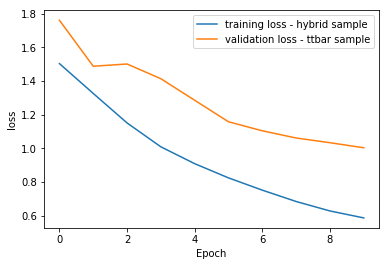

In [22]:
plt.plot(df_results['epoch'],df_results['loss'], label='training loss - hybrid sample')
plt.plot(df_results['epoch'],df_results['val_loss'], label='validation loss - ttbar sample')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

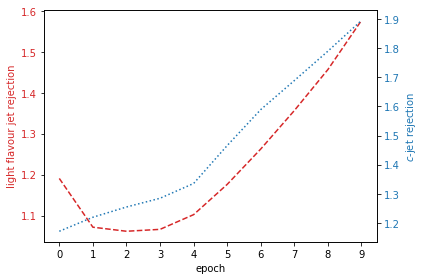

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('light flavour jet rejection', color=color)
ax1.plot(df_results["epoch"],df_results['u_rej'], '--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$c$-jet rejection', color=color)  # we already handled the x-label with ax1
ax2.plot(df_results["epoch"], df_results['c_rej'], ':', color=color, label='std = 0.12')
ax2.tick_params(axis='y', labelcolor=color)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()

## Hyper parameter optimisation
You can play with different hyper parameters and see their impact.
The largest impact has the NN-structure itself, you can try changing the number of hidden layers and their number of nodes
Other hyper parameters are the learning rate, activation function, batch size


## Model Evaluation

In [25]:
# b_effs = np.linspace(0.39, 1, 150)
# l_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('urej')
# c_rej = 1./np.load("DL1r-extbeff-22M.npy", allow_pickle=True).item().get('crej')

# l_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('urej')
# c_rej_Z = 1./np.load("DL1r-extbeff-22M-ext-Zprime.npy", allow_pickle=True).item().get('crej')

In [17]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 50000

/gpfs/slac/atlas/fs1/d/mg294/ml-tutorial/MC16d_ttbar-test-validation_sample-NN.h5
50000/50000 [==============================] - 4s 85us/step
/gpfs/slac/atlas/fs1/d/mg294/ml-tutorial/MC16d_Zprime-test-validation_sample-NN.h5
50000/50000 [==============================] - 4s 84us/step


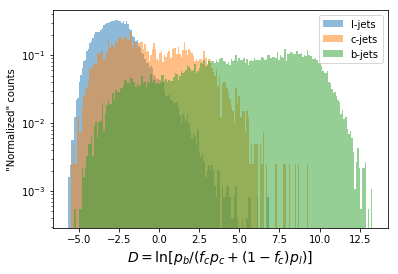

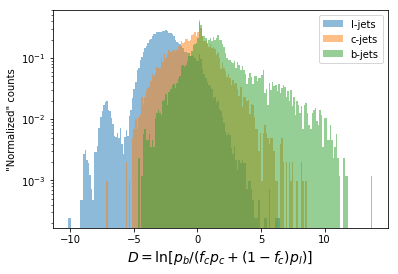

In [19]:
dl1_leffs, dl1_ceffs, dl1_beffs, dl1_discs = [], [], [], []

for testfile_name in [file_path+"/MC16d_ttbar-test-validation_sample-NN.h5",
                      file_path+"/MC16d_Zprime-test-validation_sample-NN.h5"]:
    
    print(testfile_name)
    h5f_test = h5py.File(testfile_name, 'r')

    X_test = h5f_test['X_test'][500000:]
    y_test = h5f_test['Y_test'][500000:]
    
    h5f_test.close()

    (leff, ceff, beff), d = sigBkgEff(model, X_test[:nTest], y_test[:nTest], returnDisc=True, fc=0.018)
     
    dl1_leffs.append(leff)
    dl1_ceffs.append(ceff)
    dl1_beffs.append(beff)
    dl1_discs.append(d)
        

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


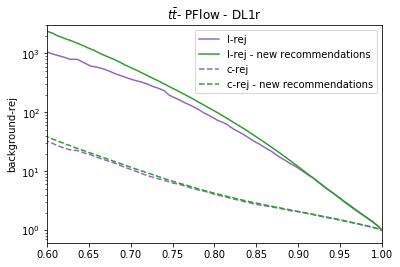

In [42]:
# ttbar
plt.figure()
plt.plot(dl1_beffs[0], 1 / dl1_leffs[0], color='C4', label='l-rej')
plt.plot(b_effs, 1./l_rej, color='C2', label='l-rej - new recommendations')

# plt.figure()
plt.plot(dl1_beffs[0], 1 / dl1_ceffs[0],"--", color='C4', label='c-rej')
plt.plot(b_effs, 1./c_rej, "--", color='C2', label='c-rej - new recommendations')

plt.ylabel('background-rej')

plt.legend()
plt.title(r'$t\bar{t}$- PFlow - DL1r')
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,3000)

plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


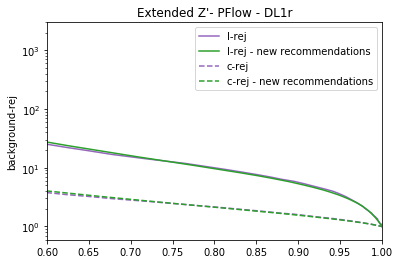

In [51]:
# Z'
plt.figure()
plt.plot(dl1_beffs[1], 1 / dl1_leffs[1], color='C4', label='l-rej')
plt.plot(b_effs, 1./l_rej_Z, color='C2', label='l-rej - new recommendations')

# plt.figure()
plt.plot(dl1_beffs[1], 1 / dl1_ceffs[1],"--", color='C4', label='c-rej')
plt.plot(b_effs, 1./c_rej_Z, "--", color='C2', label='c-rej - new recommendations')

plt.ylabel('background-rej')

plt.legend()
plt.title(r"Extended Z'- PFlow - DL1r")
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,3000)

plt.show()

## Umami

**Plan:** Let's put them together now!

In [44]:
class Sum(Layer):
    """
    Simple sum layer.
    The tricky bits are getting masking to work properly, but given
    that time distributed dense layers _should_ compute masking on their
    own.

    Author: Dan Guest
    https://github.com/dguest/flow-network/blob/master/SumLayer.py

    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

In [26]:
ppm_sizes_int = [100,100,128]
dense_sizes_int = [100,100,100]

In [49]:
_, nTrks, nFeatures = X_trk_train.shape
nClasses=3

In [53]:
trk_inputs = Input(shape=(nTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(BatchNormalization(),name="Phi{}_BatchNormalization".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# Pooling operation... sum up the track features!
F = Sum(name="Sum")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = BatchNormalization(name="F{}_BatchNormalization".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

dips_output = Dense(nClasses, activation='softmax',name="Jet_class")(F)

In [54]:
# Input layer
jet_inputs = Input(shape=(X_train.shape[1],))
# number of nodes in the different hidden layers
l_units = [72, 57, 60, 48, 36, 24, 12, 6]

# Concatenate the inputs
x = concatenate([F,jet_inputs])

# loop to initialise the hidden layers
for unit in l_units:
    x = Dense(units=unit, activation="linear", kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

dl1_output = Dense(units=nClasses, activation='softmax',
                    kernel_initializer='glorot_uniform')(x)

model = Model(inputs=[trk_inputs,jet_inputs], outputs=[dips_output,dl1_output])
model.summary()

model_optimizer = Adam(lr=0.01)
model.compile(  
    loss='categorical_crossentropy',
    optimizer=model_optimizer,
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 40, 13)       0                                            
__________________________________________________________________________________________________
masking_8 (Masking)             (None, 40, 13)       0           input_12[0][0]                   
__________________________________________________________________________________________________
Phi0_Dense (TimeDistributed)    (None, 40, 100)      1400        masking_8[0][0]                  
__________________________________________________________________________________________________
Phi0_BatchNormalization (TimeDi (None, 40, 100)      400         Phi0_Dense[0][0]                 
__________________________________________________________________________________________________
Phi0_ReLU 